# Get Bio-ARGO data

Biogeochemical Argo (“Bio-Argo” or BGC-Argo) floats are autonomous profiling instruments that drift with ocean currents and periodically dive from the surface to depths of 1,000–2,000 meters, collecting a vertical profile of physical and biogeochemical properties. Each float has a unique PLATFORM_NUMBER, and every time it dives and returns to the surface it produces a new profile, identified by its CYCLE_NUMBER. A single float may produce hundreds of profiles over several years. Bio-Argo floats carry optical, chemical, and physical sensors that measure variables such as chlorophyll-a (CHLA), temperature (TEMP), salinity (PSAL), pressure (PRES, which is used as depth), dissolved oxygen (DOXY), and nitrate (NITRATE). These data are distributed in a consistent, profile-based format: each profile contains measurements at multiple depths, along with time, latitude, longitude, and quality-control flags. To use these data for surface-matching with satellite products, we will extract the shallowest measurement in a profile and keep the value if the pressure is less than 20db (near-ish surface).

## Workflow

Here is our basic workflow.

1. Use `argopy` to fetch data for Bio-Argo profiles in a given region and time
3. For each profile, save one point, the shallowest reading.
4. Process the globe in monthly chunks to not overload the ERDDAP server and save the monthly shallow points to a parquet file.

See the version 1 notebook for how I save the first files.

In [1]:
!pip install argopy

  Using cached argopy-1.3.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached xarray-2025.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
Using cached argopy-1.3.1-py3-none-any.whl (892 kB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
Using cached xarray-2025.11.0-py3-none-any.whl (1.4 MB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: xarray━━━━━━━━━━━━━━━━━━ 0/3 [fsspec]
    Found existing installation: xarray 2025.3.1 0/3 [fsspec]
    Uninstalling xarray-2025.3.1:━━━━━━━━━━━ 0/3 [fsspec]
      Successfully uninstalled xarray-2025.3.10m 0/3 [fsspec]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [argopy]2m2/3 [argopy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

## Step 1. Get some data

In [1]:
# get some data
from argopy import DataFetcher as ArgoDataFetcher

# North Atlantic box:
region = [-70, -40, 20, 60, 0, 1000, "2024-03-01", "2024-04-01"]

fetcher_na = ArgoDataFetcher(
    ds="bgc",
    src="erddap",
    params=["CHLA", "PRES"]
)

ds_na = (
    fetcher_na
    .region(region)
    .to_xarray()
)

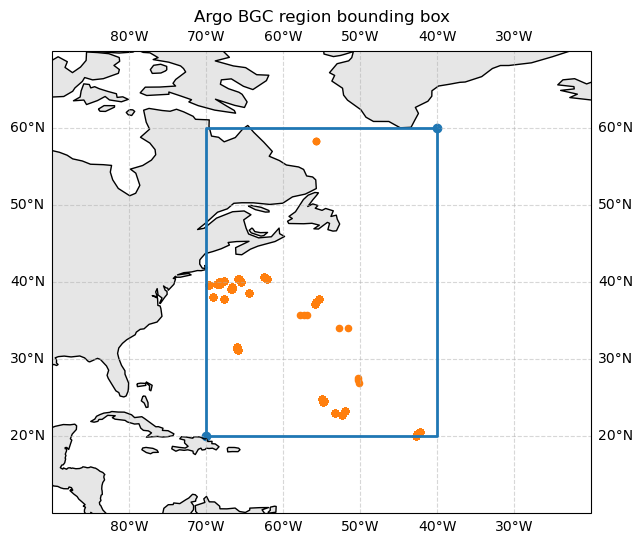

In [2]:
# plot the data; includes full profiles
lon_min, lon_max, lat_min, lat_max = region[:4]
ds = ds_na

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Corners of the box (closed loop)
lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
lats = [lat_min, lat_min, lat_max, lat_max, lat_min]

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=proj)

# Show a bit more context than just the box
ax.set_extent([lon_min - 20, lon_max + 20, lat_min - 10, lat_max + 10], crs=proj)

# Add coastlines and land
ax.coastlines(resolution="110m")
ax.add_feature(cfeature.LAND, facecolor="0.9")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)

# Plot the bounding box
ax.plot(lons, lats, transform=proj, linewidth=2)
ax.scatter([lon_min, lon_max], [lat_min, lat_max], transform=proj)

# Add the Argo points from ds
ax.scatter(
    ds["LONGITUDE"].values,
    ds["LATITUDE"].values,
    s=20,
    marker="o",
    transform=proj,
)

ax.set_title("Argo BGC region bounding box")

plt.show()



## Step 2 Filter to only one shallow point per profile

In [5]:
# get shallow points; one per profile
import numpy as np
import pandas as pd

df = ds_na.to_dataframe()

# For each profile (float+cycle), find the shallowest measurement:
df_surf = (
    df
    .sort_values("PRES")  # shallowest first
    .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
    .first()              # take the row with min PRES in each group
)

# Filter out non surface values
df_surf = df_surf[df_surf["PRES"] < 20]
df_surf = df_surf.reset_index(drop=True)

print(df_surf.head())
print("Number of profiles (shallowest samples):", len(df_surf))


   PLATFORM_NUMBER  CYCLE_NUMBER      CHLA CHLA_DATA_MODE  CHLA_ERROR  \
0          1902383            78  0.014237              A    0.028475   
1          1902383            79  0.011072              A    0.022143   
2          1902383            80  0.010280              A    0.020560   
3          1902384            79  0.025275              A    0.050550   
4          1902384            80  0.019503              A    0.039006   

   CHLA_QC DIRECTION  POSITION_QC  PRES PRES_DATA_MODE  ...  PSAL_ERROR  \
0        5         A            1  2.09              A  ...         NaN   
1        5         A            1  2.28              A  ...         NaN   
2        5         A            1  2.35              A  ...         NaN   
3        1         A            1  2.26              A  ...         NaN   
4        5         A            1  0.84              A  ...         NaN   

   PSAL_QC       TEMP TEMP_DATA_MODE  TEMP_ERROR  TEMP_QC  TIME_QC LATITUDE  \
0        1  24.818001          

## Put it together to process the globe

Those are the 2 steps that we will do for each part of the globe and each month since March 2024. We create a function that combines these 2 steps to get one month of data for a region and then we use a for loop to work through the globe. We save the processed monthly data.

### A function to get one month

Get a month for a region. Return a dataframe of the shallow points only.

In [8]:
# get_bgc_surface()
from pathlib import Path

import numpy as np
import pandas as pd
from argopy import DataFetcher as ArgoDataFetcher

def get_bgc_surface(reg, mon, data_dir="data", vars=None, save=False):
    """
    Fetch near-surface Bio-Argo data for a region and month and (optionally) save as parquet.

    Parameters
    ----------
    reg : sequence
        [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
        (same as argopy region, but without time bounds).
    mon : str or datetime-like
        Month to fetch, e.g. "2024-03" or "2024-03-01".
    data_dir : str, optional
        Directory where the parquet file will be saved.
    vars : list of str, optional
        Additional Bio-Argo variables to fetch (e.g. ["CHLA", "BBP700", "DOXY"]).
        Defaults to ["CHLA"].
    save : bool, optional
        If True, save a parquet file and return (df_surf, path).
        If False, just return (df_surf, None).

    Returns
    -------
    df_surf : pandas.DataFrame
        Near-surface samples (one row per profile) with requested variables.
    out_path : str or None
        Path to the saved parquet file, or None if save=False.

    Example
    -------
    params = ["CHLA", "BBP700", "DOXY", "PRES"]
    region = [-70, -10, 0, 60, 0, 100]
    month = "2024-03"
    df_surf, path = get_bgc_surface(region, month, vars=params)
    """
    if vars is None:
        vars = ["CHLA"]  # default behaviour

    # Ensure uniqueness and preserve order
    extra_vars = list(dict.fromkeys(vars))

    lon_min, lon_max, lat_min, lat_max, z_min, z_max = reg

    # Compute start/end of the month
    mon_start = pd.to_datetime(mon).to_period("M").start_time
    mon_end   = (mon_start + pd.offsets.MonthBegin(1))

    region = [
        lon_min, lon_max,
        lat_min, lat_max,
        z_min, z_max,
        mon_start.strftime("%Y-%m-%d"),
        mon_end.strftime("%Y-%m-%d"),
    ]

    # Columns we expect in the output DataFrame
    base_cols = [
        "PLATFORM_NUMBER", "CYCLE_NUMBER",
        "TIME", "LATITUDE", "LONGITUDE", "PRES",
    ]
    # Add requested vars (e.g. CHLA, BBP700, DOXY, etc.) if not already present
    cols = base_cols + [v for v in extra_vars if v not in base_cols]

    # STEP 1: Get data for region + month
    # argopy `params` are geophysical variables; platform/time/lat/lon come along
    param_vars = list(dict.fromkeys(extra_vars + ["PRES"]))  # PRES always needed

    fetcher = ArgoDataFetcher(
        ds="bgc",
        src="erddap",
        params=param_vars,
    )

    try:
        ds = fetcher.region(region).to_xarray()
    except Exception as exc:
        print(f"No data for region={reg}, month={mon}: {exc}")
        return pd.DataFrame(columns=cols), None

    # STEP 2: Filter to approximate surface data
    # (select only the columns we care about)
    try:
        df_all = ds[cols].to_dataframe().reset_index(drop=True)
    except KeyError as exc:
        # In case some requested vars are missing in this box/month
        missing = [c for c in cols if c not in ds.variables and c not in ds.coords]
        print(f"Missing variables {missing} for region={reg}, month={mon}: {exc}")
        return pd.DataFrame(columns=cols), None

    if df_all.empty:
        print(f"No data rows for region={reg}, month={mon}")
        return pd.DataFrame(columns=cols), None

    # Drop rows with missing PRES
    df_all = df_all.dropna(subset=["PRES"])
    if df_all.empty:
        print(f"No rows with valid PRES for region={reg}, month={mon}")
        return pd.DataFrame(columns=cols), None

    # For each profile (float+cycle), find the shallowest measurement
    df_surf = (
        df_all
        .sort_values("PRES")  # shallowest first
        .groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"], as_index=False)
        .first()              # row with min PRES per profile
    )

    # Filter out non-surface values
    df_surf = df_surf[df_surf["PRES"] < 20].reset_index(drop=True)

    # If everything disappeared after the surface filter, return an empty, typed DF
    if df_surf.empty:
        print(f"No near-surface rows for region={reg}, month={mon}")
        return pd.DataFrame(columns=cols), None

    # STEP 3: Save to parquet in data/ dir (optional)
    data_path = Path(data_dir)
    data_path.mkdir(parents=True, exist_ok=True)

    out_fname = (
        f"argo_bgc_{lat_min}_{lat_max}_{lon_min}_{lon_max}_"
        f"{mon_start.strftime('%Y%m')}.parquet"
    )
    out_path = data_path / out_fname

    if save:
        df_surf.to_parquet(out_path, index=False)
        return df_surf, str(out_path)

    return df_surf, None


In [ ]:
# Example
params = ["CHLA", "BBP700", "DOXY", "PRES"]
region = [-70, -10, 0, 60, 0, 100]
month = "2024-03"
df_surf, _ = get_bgc_surface(region, month, vars=params)
df_surf

### A for loop to work through the whole globe

Loop through the globe and save monthly files. We will do this for all months when there is PACE data. This will take about an hour but we only have to do it once.

In [ ]:
# loop to work through the globe
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Variables to get if avail. NaN if missing
BGC_VARS = [
    "CHLA", "BBP700", "DOXY",
    "PSAL", "TEMP", "NITRATE", "PH_IN_SITU_TOTAL",
]

out_dir = Path("data/monthly")
out_dir.mkdir(parents=True, exist_ok=True)

# Months from 2024-03 up to the current month
start_month = "2024-03"
end_month = pd.Timestamp.today().to_period("M")
months = pd.period_range(start_month, end_month, freq="M")

for mon in months:
    month_str = mon.strftime("%Y-%m")
    out_path = out_dir / f"argo_bgc_global_{month_str}.parquet"

    # Skip if we already have this month (so reruns don't redo everything)
    if out_path.exists():
        print(f"Skipping {month_str}, already have {out_path}")
        continue

    print(f"\n=== Processing month {month_str} ===")

    dfs = []  # collect all boxes for this month

    # Latitude: 45° bands from -90 to 90 -> 4 bands
    for lat_min in range(-90, 90, 45):
        lat_max = lat_min + 45

        # Longitude: 60° bands from -180 to 180 -> 6 bands
        for lon_min in range(-180, 180, 60):
            lon_max = lon_min + 60
            region = [lon_min, lon_max, lat_min, lat_max, 0, 100]
            df_box, _ = get_bgc_surface(region, month_str, vars=BGC_VARS, save=False)
            if df_box is None or df_box.empty: continue
            dfs.append(df_box)

    # Desired column order (core metadata + all BGC vars)
    base_cols = [
        "TIME", "LATITUDE", "LONGITUDE",
        "PRES", "PLATFORM_NUMBER", "CYCLE_NUMBER",
    ]
    cols = base_cols + BGC_VARS

    if not dfs:
        print(f"No data at all for month {month_str}, writing empty file")
        df_month = pd.DataFrame(columns=cols)
    else:
        df_month = pd.concat(dfs, ignore_index=True)

        # Make sure all expected columns exist; if missing, add as NaN
        for c in cols:
            if c not in df_month.columns:
                df_month[c] = np.nan

        # Now safely reorder columns
        df_month = df_month[cols]

    # Save one file per month
    df_month.to_parquet(out_path, index=False)
    print(f"Saved {len(df_month)} rows for {month_str} to {out_path}")


=== Processing month 2024-03 ===


No data rows for region=[-120, -60, -90, -45, 0, 100], month=2024-03


No data rows for region=[-60, 0, -90, -45, 0, 100], month=2024-03
